In [34]:
import sympy as sp
import jax.numpy as np
from jax import vmap
import matplotlib.pyplot as plt

from util.interfaces import Config, EqInfo, Hyperparameters, VarInfo
from main import run

## Problem
$ \displaystyle
\frac{dP}{dt} = rP
$

$ \displaystyle
P(1) = e^{r}
$

Analytical solution:
$ \displaystyle
P = e^{rt}
$

In [35]:
config = Config(
  eq = EqInfo(
    name = 'P',
    function = lambda s: s.dPdt - s.r * s.P,
  ),
  vars = {
    'r': VarInfo(bounds=(1, 2), integrable=False),
    't': VarInfo(bounds=(0, 2), integrable=False),
  },
  conditions = [
    (2, lambda s: s.P.subs(s.t, 1) - sp.exp(s.r))
  ],
  preoperations = [
    lambda r, t: 0,
    lambda r, t: 1,
    lambda r, t: r,
    lambda r, t: t,
    lambda r, t: r * t
  ],
  operations = [
    lambda z: 0,
    lambda z: 1,
    lambda z: z,
    lambda z: -z,
    lambda z: z*z,
    lambda z: sp.exp(z) + 0,
  ],
  hyperparameters = Hyperparameters(
    lr = 0.01,
    penalty = 2,
    cellcount = 4,
  ),
  epochs = 32,
  batchsize = 64,
  verbosity = 1,
  seed = 2,
)


In [36]:
network, best, loss_histories = run(config)

13:20:08.730 [INFO] Constructed symbolic model
13:20:08.247 [INFO] Constructed loss equation
13:20:08.521 [INFO] Constructed JAXified model
13:20:10.520 [INFO] Epoch: 1, Loss: 47.4419174194
13:20:10.111 [INFO] Epoch: 2, Loss: 26.6977081299
13:20:10.168 [INFO] Epoch: 3, Loss: 18.3888282776
13:20:10.209 [INFO] Epoch: 4, Loss: 35.3190345764
13:20:10.244 [INFO] Epoch: 5, Loss: 6.3753089905
13:20:10.279 [INFO] Epoch: 6, Loss: 10.0150213242
13:20:10.313 [INFO] Epoch: 7, Loss: 4.3458051682
13:20:10.347 [INFO] Epoch: 8, Loss: 2.9161472321
13:20:10.387 [INFO] Epoch: 9, Loss: 1.9903391600
13:20:10.429 [INFO] Epoch: 10, Loss: 1.3507220745
13:20:10.464 [INFO] Epoch: 11, Loss: 0.9252351522
13:20:10.501 [INFO] Epoch: 12, Loss: 1.1371681690
13:20:10.535 [INFO] Epoch: 13, Loss: 1.0737104416
13:20:10.569 [INFO] Epoch: 14, Loss: 1.1337811947
13:20:10.603 [INFO] Epoch: 15, Loss: 0.5858132839
13:20:10.638 [INFO] Epoch: 16, Loss: 0.4838229120
13:20:10.671 [INFO] Epoch: 17, Loss: 0.5162397623
13:20:10.706 [

Nothing more to prune!


$\displaystyle 0.999994814395905 e^{0.999996483325958 r t} - 6.23068171989871 \cdot 10^{-6}$

Best loss: 1.4425542704810113e-10


In [37]:
prediction_best = best.model.subs(zip(best.alphas, best.W))
print(sp.latex(prediction_best))

0.999994814395905 e^{0.999996483325958 r t} - 6.23068171989871 \cdot 10^{-6}


# Plot

In [38]:
r = network.symbols.r
t = network.symbols.t

In [39]:
y_pred_fn = sp.lambdify([r, t], prediction_best)
y_real_fn = sp.lambdify([r, t], sp.exp(r*t))

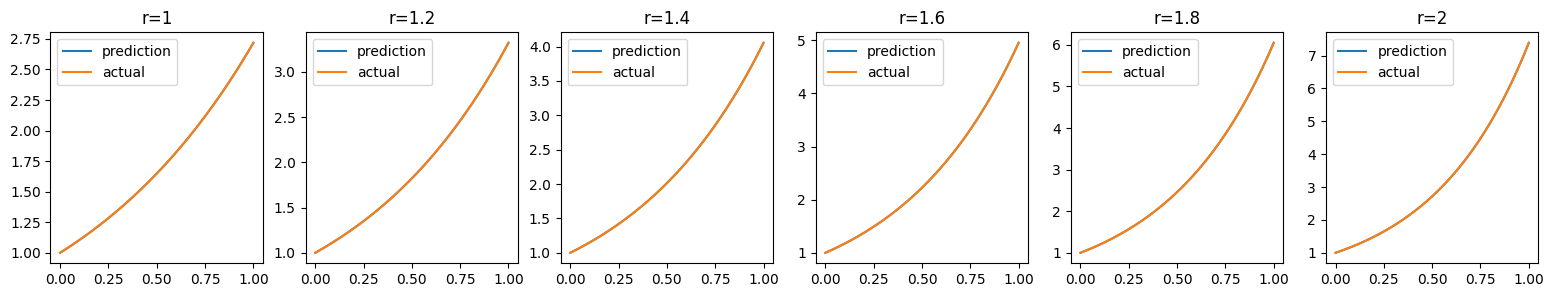

In [40]:
t_try = np.linspace(0, 1, 50)

r_tries = [1, 1.2, 1.4, 1.6, 1.8, 2]
fig, axs = plt.subplots(1, len(r_tries))
fig.set_size_inches(len(r_tries)*3.2, 3)

for ax, r_try in zip(axs, r_tries):
  ax.set_title(f'r={r_try}')
  ax.plot(t_try, y_pred_fn(r_try, t_try), label=f'prediction')
  ax.plot(t_try, y_real_fn(r_try, t_try), label=f'actual')
  ax.legend()
plt.show()

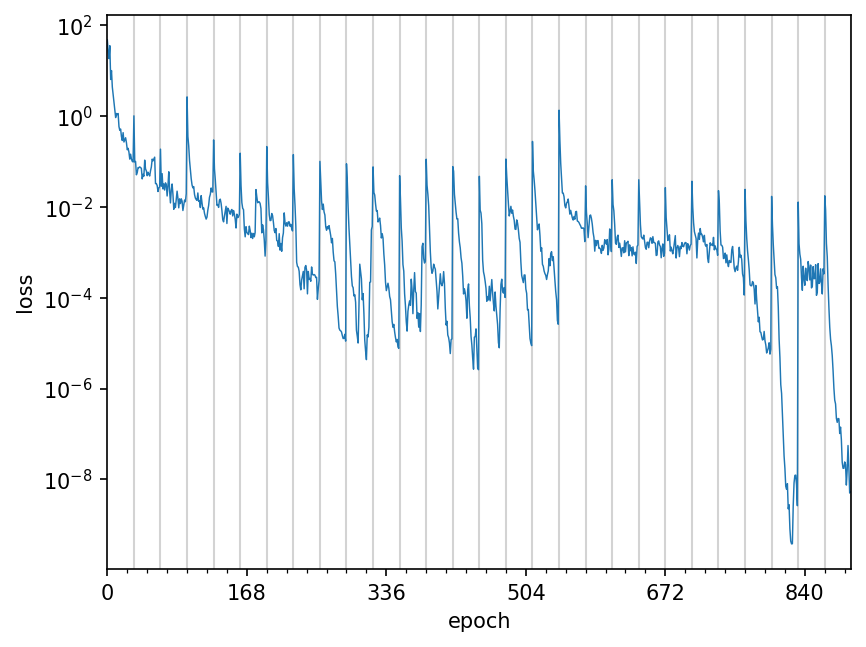

In [41]:
from itertools import chain

loss_history = []
prunepoints = []

for pruneepoch in loss_histories:
  count = 0 if len(prunepoints) == 0 else prunepoints[len(prunepoints)-1]
  for epoch in pruneepoch:
    loss_history += [np.average(np.array(epoch))]
    count += 1
  prunepoints += [count]

plt.xlabel('epoch')
plt.xlim((0, prunepoints[len(prunepoints) - 1]))
# plt.ylim((min(loss_history)*0.5, 2))
plt.gcf().gca().xaxis.set_major_locator(plt.MultipleLocator(168))
plt.gcf().gca().xaxis.set_minor_locator(plt.MultipleLocator(24))
plt.yscale('log')
plt.ylabel('loss')
for prunepoint in prunepoints:
  plt.axvline(prunepoint, color='lightgrey', linewidth=1)
plt.plot(loss_history, linewidth=0.7)
plt.gcf().set_dpi(150)
plt.show()

# Test

In [42]:
dPdt = sp.diff(prediction_best, 't')

loss = (dPdt - network.symbols.r * prediction_best)**2

sp.integrate(loss, ('t', *config.vars['t'].bounds), ('r', *config.vars['r'].bounds))

6.52490784350316e-9

In [43]:
P = sp.exp(r*t)

dPdt = sp.diff(P, t)

loss = (dPdt - r * P)**2

sp.integrate(loss, ('t', *config.vars['t'].bounds), ('r', *config.vars['r'].bounds))

0